# EE502 Lab 03

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg


## Define Python function to calculate objective
def func_1(x):
    a = np.array([0.3, 0.6, 0.2])
    b = np.array([5, 26, 3])
    c = np.array([40, 1, 10])
    
    # Intermediates. Recall Python indicies start at 0
    u = x[0] - 0.8
    s = np.sqrt(1-u)
    s2 = np.sqrt(1+u)
    v = x[1] -(a[0] + a[1]*u**2*s-a[2]*u)
    alpha = -b[0] + b[1]*u**2*s2+ b[2]*u # September 5, 2018: changed 's' to 's2'
    beta = c[0]*v**2*(1-c[1]*v)/(1+c[2]*u**2)
    
    return alpha*np.exp(-beta)

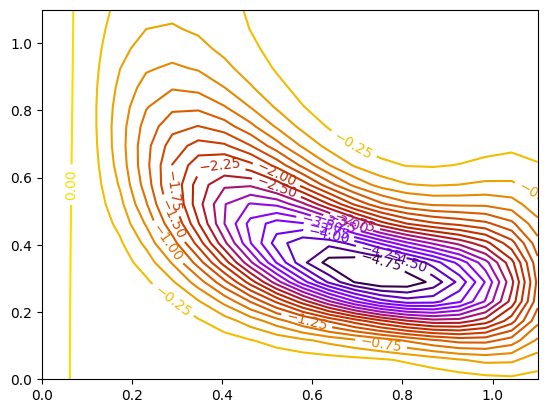

In [14]:
x = np.linspace(0, 1.1, 20)
y = np.linspace(0, 1.1, 20)
z = np.zeros(([len(x), len(y)]))

for i in range(0, len(x)):
    for j in range(0, len(y)):
        z[j, i] = func_1([x[i], y[j]])
    
contours=plt.contour(x, y, z, 20, cmap=plt.cm.gnuplot)
plt.clabel(contours, inline=1, fontsize=10)
plt.show()

In [15]:
## Calculate gradient with central finite difference
def grad_central(x,f,eps1):
    n = len(x)
    grad = np.zeros(n)
 
    for i in range(0,n):
        # Create vector of zeros except eps in position i
        e = np.zeros(n)
        e[i] = eps1
 
        # Finite difference formula
        f_plus = f(x + e)
        f_minus = f(x - e)
        grad[i] = (f_plus - f_minus)/(2*eps1)
 
    return grad


## Calculate gradient using central finite difference and my_hes_approx
def hes_central(x,grad,eps2):
    n = len(x)
    H = np.zeros([n,n])
 
    for i in range(0,n):
        # Create vector of zeros except eps in position i
        e = np.zeros(n)
        e[i] = eps2
 
        # Evaluate gradient twice
        grad_plus = grad(x + e)
        grad_minus = grad(x - e)
    
        # Notice we are building the Hessian by column (or row)
        H[:,i] = (grad_plus - grad_minus)/(2*eps2)

    return H


def check_nan(A):
 return np.sum(np.isnan(A))


def act_hes(B):
    print(B,"\n")
    if not check_nan(B):
        # Calculate eigenvalues
        l = linalg.eigvals(B)
        print("Eigenvalues: ",l,"\n")


In [16]:
# Algorithm for pure newton method
def Newton_Pure(x0,comp_f,comp_grad,comp_hes,eps1,eps2,max_iter=250): 
    # assign outputs as empty lists
    x = []
    f = []
    p = []
    
    # Store starting point
    x.append(x0)
    k = 0    
    flag = True    
    print("Iter. \tf(x) \t\t||grad(x)|| \t||p|| \t\tmin(lambda)")
    
    while flag:
        # Evaluate f(x) at current iteration
        f.append(comp_f(x[k]))
        
        # Evaluate gradient
        grad = comp_grad(x[k])
        
        if(check_nan(grad)):
            print("WARNING: gradiant calculation returned NaN")
            break
 
        # Evaluate Hessian
        hes = comp_hes(x[k])
        
        if(check_nan(hes)):
            print("WARNING: Hessian calculation returned NaN")
            break 
 
        # Check if singular via condition number
        c = np.linalg.cond(hes)
        if c > 1E12:
            flag = False
            print("Warning: Hessian is near singular.")
        else:
            # Calculate step 
            p.append(linalg.solve(hes,-grad)) 
            
            # Take step. x[k+1] = x[k] + p[k]
            x.append(x[k] + p[k])
            
            # Calculate norms
            norm_p = linalg.norm(p[k])
            norm_g = linalg.norm(grad)
            
            # Calculate eigenvalues (for display only)
            ev = np.real(linalg.eigvals(hes))
            
            # print("k = ",k,"\t"f[k],"\t",norm_g,"\t",norm_p)
            print(k,' \t{0: 1.4e} \t{1:1.4e} \t{2:1.4e} \t{3: 1.4e}'.format(f[k],norm_g,norm_p,np.min(ev)))
            
            # Check convergence criteria
            flag = (norm_p > eps1) and (norm_g > eps2)
            
            # Update iteration counter
            k = k + 1
            
        if k > max_iter:
            flag = False
            print("Maximum number of iterations.")
            
    print("Done.")
    print("x* = ",x[-1])
 
    return x,f,p

In [17]:
## Test this code on the above given problem 

# Specify convergence criteria
eps1 = 1E-8
eps2 = 1E-4

# Create a Lambda function for gradient calculation
comp_grad = lambda x : grad_central(x,func_1,1E-6)

# Create a Lambda function for Hessian calculation
comp_hes = lambda x : hes_central(x,comp_grad,1E-6)

# Recall that the Newton method does well for points close to the optimal solution.Accordingly specify starting point .
x0 = np.array([1.7,0.3])

# Call optimization routine
x,f,p = Newton_Pure(x0,func_1,comp_grad,comp_hes,eps1,eps2);

# Actual Hessian
print("Hessian at x*= ")
act_hes(hes_central(x[-1],comp_grad,1E-6))

Iter. 	f(x) 		||grad(x)|| 	||p|| 		min(lambda)
0  	 2.6650e+01 	7.1615e+01 	1.4062e+00 	-2.8886e+02
1  	-1.6738e-01 	1.4974e+00 	3.7777e-01 	-1.3054e+01
2  	-2.3730e-02 	1.9469e-01 	7.1745e-02 	-2.9434e+00
3  	-1.5143e-02 	6.3620e-02 	5.1540e-02 	-1.7639e+00
4  	-1.3356e-02 	8.0249e-03 	8.0475e-03 	-1.5579e+00
5  	-1.3324e-02 	6.1570e-05 	5.0780e-05 	-1.5565e+00
Done.
x* =  [0.80557694 0.96556989]
Hessian at x*= 
[[-1.47003937 -0.2060214 ]
 [-0.2060214  -1.06562545]] 

Eigenvalues:  [-1.55650605+0.j -0.97915877+0.j] 



## Excercise 1

Run the program for the other starting points and decide if Pure Newton search is a good method for this problem. Why do you think Newton mehtodss fails for this problem?

In [18]:
## Do the same with a different initial point.
x0 = np.array([1, 0.5])

# Call the Newton routine
x,f,p = Newton_Pure(x0,func_1,comp_grad,comp_hes,eps1,eps2);

# Actual Hessian
print("Hessian at x* = ")
act_hes(hes_central(x[-1],comp_grad,1E-6))

Iter. 	f(x) 		||grad(x)|| 	||p|| 		min(lambda)
0  	-1.1226e+00 	9.5731e+00 	1.3415e-01 	-7.2252e+01
1  	-3.7785e-01 	3.3652e+00 	1.1713e-01 	-2.7965e+01
2  	-1.5207e-01 	1.2696e+00 	1.1264e-01 	-1.0021e+01
3  	-8.2078e-02 	4.8931e-01 	9.4696e-02 	-3.8544e+00
4  	-6.6590e-02 	1.5247e-01 	1.9901e-02 	-2.7999e+00
5  	-6.6956e-02 	1.5903e-02 	1.7322e-03 	-3.0320e+00
6  	-6.6964e-02 	2.0630e-04 	1.7720e-05 	-3.0340e+00
7  	-6.6964e-02 	3.6909e-08 	3.1486e-09 	-3.0342e+00
Done.
x* =  [1.07689587 0.95040621]
Hessian at x* = 
[[11.75045825  0.16828899]
 [ 0.16828899 -3.03225153]] 

Eigenvalues:  [11.75237383+0.j -3.03416712+0.j] 



## Exercise 2


Replace the Hessian of the function with the identity matrix and test the algorith. Write down your observations.

In [19]:
def Id_hes(x):
    return 50*np.eye(len(x))

In [20]:
# Specify starting point
x0 = np.array([0.9, 0.3])

# Create a Lambda (anonymous) function for gradient calculation
comp_grad = lambda x : grad_central(x,func_1,1E-6);

# Call optimization routine
x,f,p = Newton_Pure(x0,func_1,comp_grad,Id_hes,eps1,eps2,max_iter=25);

# Actual Hessian
print("Hessian at x* = ")
act_hes(hes_central(x[-1],comp_grad,1E-6))

Iter. 	f(x) 		||grad(x)|| 	||p|| 		min(lambda)
0  	-4.3949e+00 	9.9226e+00 	1.9845e-01 	 5.0000e+01
1  	-3.1017e+00 	3.0416e+01 	6.0832e-01 	 5.0000e+01
2  	-3.4219e-02 	3.3383e-01 	6.6766e-03 	 5.0000e+01
3  	-3.6551e-02 	3.6494e-01 	7.2988e-03 	 5.0000e+01
4  	-3.9348e-02 	4.0216e-01 	8.0432e-03 	 5.0000e+01
5  	-4.2762e-02 	4.4744e-01 	8.9488e-03 	 5.0000e+01
6  	-4.7012e-02 	5.0363e-01 	1.0073e-02 	 5.0000e+01
7  	-5.2437e-02 	5.7506e-01 	1.1501e-02 	 5.0000e+01
8  	-5.9576e-02 	6.6858e-01 	1.3372e-02 	 5.0000e+01
9  	-6.9342e-02 	7.9565e-01 	1.5913e-02 	 5.0000e+01
10  	-8.3398e-02 	9.7676e-01 	1.9535e-02 	 5.0000e+01
11  	-1.0506e-01 	1.2519e+00 	2.5038e-02 	 5.0000e+01
12  	-1.4185e-01 	1.7083e+00 	3.4166e-02 	 5.0000e+01
13  	-2.1402e-01 	2.5682e+00 	5.1365e-02 	 5.0000e+01
14  	-3.9235e-01 	4.5293e+00 	9.0586e-02 	 5.0000e+01
15  	-1.0397e+00 	1.0295e+01 	2.0589e-01 	 5.0000e+01
16  	-3.9079e+00 	1.2683e+01 	2.5367e-01 	 5.0000e+01
17  	-2.4319e+00 	2.9530e+01 	5.9061e-01 	 5.

The following code implements Levenberg-Marquadt cerrection to the Hessian.

In [21]:
def Leven_hes(x,grad,eps2,eps3):
    # Estimate Hessian with finite difference
    hes = hes_central(x,grad,eps2)
    
    # Calculate eigenvalues
    l, V = linalg.eig(hes)
    smallest_eigv = np.min(np.real(l))
    
    # Calculate Levenberg-Marquardt modification
    delta = 0
    if(smallest_eigv - eps3 < 0):
        delta = -smallest_eigv + eps3 
 
    # Adjust hessian with Levenberg-Marquardt Correction
    return V.dot(np.diag(np.real(l)) + delta*np.eye(len(x))).dot(V.T)

In [22]:
# Specify starting point
x0 = np.array([1, .3])

# Create a Lambda (anonymous) function for Hessian calculation
comp_hes = lambda x : Leven_hes(x,comp_grad,1E-6,1E-3)

# Call optimization routine
x,f,p = Newton_Pure(x0,func_1,comp_grad,comp_hes,eps1,eps2);

# Actual Hessian
print("Hessian at x*= ")
act_hes(hes_central(x[-1],comp_grad,1E-6))

Iter. 	f(x) 		||grad(x)|| 	||p|| 		min(lambda)
0  	-3.2295e+00 	1.5005e+01 	2.5673e-01 	 5.8444e+01
1  	-4.2079e+00 	2.4956e+01 	9.5064e-02 	 5.3081e+01
2  	-4.9161e+00 	1.1487e+01 	3.6621e-02 	 2.7834e+01
3  	-5.0856e+00 	1.5759e+00 	7.1264e-03 	 4.4380e+01
4  	-5.0893e+00 	9.9492e-03 	1.4925e-04 	 4.3408e+01
5  	-5.0893e+00 	4.9238e-06 	1.1706e-08 	 4.3417e+01
Done.
x* =  [0.73950546 0.3143601 ]
Hessian at x*= 
[[ 77.01217442 108.33423048]
 [108.33423048 392.76670805]] 

Eigenvalues:  [ 43.41741489+0.j 426.36146757+0.j] 



## Excercise 3

Is the Lvenberg Marquadt correction better in finding the minimum? Justify your answer.

## Exercise 4

Do the exercises 1-3 for the function `x_1^4 + x_1x_2 + (1 + x_2)^2` starting at initial point `x_0 = [0, 0]`.